# Polymer + particle mixture using pyPRISM

In [64]:
import pyPRISM
import matplotlib.pyplot as plt
from custom_prism_tools.DiscreteKoyamaPartitioned import DiscreteKoyamaPartitioned
from custom_prism_tools.DiscreteKoyama import DiscreteKoyama
from custom_prism_tools.KovalenkoHirata import KovalenkoHirata
from custom_prism_tools.ShiftedWeeksChandlerAnderson import ShiftedWeeksChandlerAnderson
import numpy as np

## Tunable parameters

In [231]:
#parameters to set
length = 10
particle_eta = 0.01
N_polymer__N_particle = 1.0
particle_diameter = 5.0
polymer_site_diameter = 1.0
bond_length = 0.97
persistence_length = 4./3.
epsilon = 1.0
length_scale = polymer_site_diameter

In [232]:
#dependent parameters
particle_density = 6.0*particle_eta/(np.pi*particle_diameter**3.0)
polymer_density = N_polymer__N_particle*particle_density
polymer_site_density = length*polymer_density

In [234]:
# The system holds all information needed to set up a PRISM problem. We
# instantiate the system by specifying the site types and thermal energy
# level (kT, coarse-grained temperature) of the system.
sys = pyPRISM.System(['particle','polymer_middle','polymer_end'], kT=1.0)

# We must discretize Real and Fourier space
sys.domain = pyPRISM.Domain(dr=0.01,length=4096)

# The composition of the system is desribed via number densities
sys.density['particle'] = particle_density
sys.density['polymer_end']  = polymer_site_density*(2.0/float(length))
sys.density['polymer_middle']  = polymer_site_density*(float(length-2)/float(length))

# The diameter of each site is specified (in reduced units)
sys.diameter['particle'] = particle_diameter
sys.diameter['polymer_end'] = polymer_site_diameter
sys.diameter['polymer_middle'] = polymer_site_diameter

# The molecular structure is described via intra-molecular correlation
# functions (i.e. omegas)
sys.omega['particle','particle'] = pyPRISM.omega.SingleSite()
sys.omega['particle','polymer_end'] = pyPRISM.omega.InterMolecular()
sys.omega['particle','polymer_middle'] = pyPRISM.omega.InterMolecular()
sys.omega['polymer_end','polymer_end'] = DiscreteKoyamaPartitioned(sigma=polymer_site_diameter, 
                                                                   l=bond_length, 
                                                                   length=length, 
                                                                   lp=persistence_length, 
                                                                   types=('end','end'))
sys.omega['polymer_middle','polymer_middle'] = DiscreteKoyamaPartitioned(sigma=polymer_site_diameter, 
                                                                         l=bond_length, 
                                                                         length=length, 
                                                                         lp=persistence_length, 
                                                                         types=('middle','middle'))
sys.omega['polymer_end','polymer_middle'] = DiscreteKoyamaPartitioned(sigma=polymer_site_diameter, 
                                                                      l=bond_length, 
                                                                      length=length, 
                                                                      lp=persistence_length, 
                                                                      types=('end','middle'))

# The site-site interactions are specified via classes which are lazily
# evaluated during the PRISM-object creation
particle_polymer_cross_diameter = (particle_diameter + polymer_site_diameter)/2.0

sys.potential['particle','particle'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                    length_scale=length_scale,
                                                                    sigma=particle_diameter)
sys.potential['particle','polymer_end'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                       length_scale=length_scale,
                                                                       sigma=particle_polymer_cross_diameter)
sys.potential['particle','polymer_middle'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                          length_scale=length_scale,
                                                                          sigma=particle_polymer_cross_diameter)
sys.potential['polymer_end','polymer_end'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                          length_scale=length_scale,
                                                                          sigma=polymer_site_diameter)
sys.potential['polymer_middle','polymer_middle'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                                length_scale=length_scale,
                                                                                sigma=polymer_site_diameter)
sys.potential['polymer_end','polymer_middle'] = ShiftedWeeksChandlerAnderson(epsilon=epsilon, 
                                                                             length_scale=length_scale,
                                                                             sigma=polymer_site_diameter)


sys.potential['particle','particle'] = pyPRISM.potential.HardSphere(sigma=particle_diameter)
sys.potential['particle','polymer_end'] = pyPRISM.potential.HardSphere(sigma=(particle_diameter + polymer_site_diameter)/2.0)
sys.potential['particle','polymer_middle'] = pyPRISM.potential.HardSphere(sigma=(particle_diameter + polymer_site_diameter)/2.0)
sys.potential['polymer_end','polymer_end'] = pyPRISM.potential.HardSphere(sigma=polymer_site_diameter)
sys.potential['polymer_middle','polymer_middle'] = pyPRISM.potential.HardSphere(sigma=polymer_site_diameter)
sys.potential['polymer_end','polymer_middle'] = pyPRISM.potential.HardSphere(sigma=polymer_site_diameter)



# Closure approximations are also specified via classes
sys.closure['particle','particle'] = KovalenkoHirata()
sys.closure['particle','polymer_end'] = KovalenkoHirata()
sys.closure['particle','polymer_middle'] = KovalenkoHirata()
sys.closure['polymer_end','polymer_end'] = KovalenkoHirata()
sys.closure['polymer_middle','polymer_middle'] = KovalenkoHirata()
sys.closure['polymer_end','polymer_middle'] = KovalenkoHirata()

# Calling the .solve() method of the system object attempts to numerically
# solv the PRISM equation and, if successful, it returns a PRISM object
# containing all of the solved correlation functions.
PRISM = sys.solve(guess=guess, method='krylov')

# Calculate the pair-correlation functions.
rdf = pyPRISM.calculate.pair_correlation(PRISM)


0:  |F(x)| = 247.277; step 0.194332; tol 0.566267
1:  |F(x)| = 245.035; step 1; tol 0.883756
2:  |F(x)| = 162.773; step 1; tol 0.702923
3:  |F(x)| = 24.8076; step 1; tol 0.444691
4:  |F(x)| = 21.0913; step 1; tol 0.650548
5:  |F(x)| = 16.8191; step 1; tol 0.572324
6:  |F(x)| = 16.8175; step 1; tol 0.899831
7:  |F(x)| = 16.8175; step 1; tol 0.9
8:  |F(x)| = 16.8175; step 1; tol 0.9
9:  |F(x)| = 16.8178; step 1; tol 0.900037
10:  |F(x)| = 16.8177; step 1; tol 0.89999
11:  |F(x)| = 16.8176; step 1; tol 0.899979
12:  |F(x)| = 16.8175; step 1; tol 0.899993
13:  |F(x)| = 16.7602; step 1; tol 0.89388
14:  |F(x)| = 16.7502; step 1; tol 0.89892
15:  |F(x)| = 16.7499; step 1; tol 0.899975
16:  |F(x)| = 16.7505; step 1; tol 0.900065
17:  |F(x)| = 16.7501; step 0.500038; tol 0.899949
18:  |F(x)| = 9.20597; step 1; tol 0.728917
19:  |F(x)| = 6.64539; step 1; tol 0.478188
20:  |F(x)| = 2.60499; step 1; tol 0.205798
21:  |F(x)| = 0.16536; step 1; tol 0.00362654
22:  |F(x)| = 0.00130296; step 1; tol 5

In [235]:
guess = np.copy(PRISM.x)

In [267]:
rdf = pyPRISM.calculate.pair_correlation(PRISM)

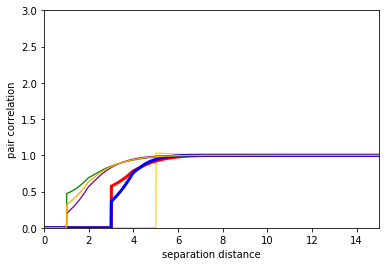

In [219]:
# Plot the results using matplotlib
plt.plot(sys.domain.r,rdf['particle','particle'],color='gold',lw=1.25,ls='-')
plt.plot(sys.domain.r,rdf['particle','polymer_end'],color='red',lw=3,ls='-')
plt.plot(sys.domain.r,rdf['particle','polymer_middle'],color='blue',lw=3,ls='-')
plt.plot(sys.domain.r,rdf['polymer_end','polymer_end'],color='green',lw=1.25,ls='-')
plt.plot(sys.domain.r,rdf['polymer_middle','polymer_middle'],color='purple',lw=1.25,ls='-')
plt.plot(sys.domain.r,rdf['polymer_end','polymer_middle'],color='orange',lw=1.25,ls='-')
plt.ylabel('pair correlation')
plt.xlabel('separation distance')
plt.xlim(0,15)
plt.ylim(0,3)
plt.show()

## Testing free energy for HS

In [93]:
F_P = []
etas = np.arange(0.01, 0.6, 0.01)
for eta in etas:
    print eta
    sys.density['particle'] = 6.0*eta/(np.pi*particle_diameter**3.0)
    PRISM = sys.solve(guess=guess, method='krylov')
    guess = np.copy(PRISM.x)
    F_P.append(ExcessFreeEnergy(PRISM, default_method='HNC'))
F_P = np.array(F_P)

0.01
0:  |F(x)| = 5.07276e-13; step 1; tol 7.74786e-12
(9.432884094158487e-06, -3.204771179667925e-06)
0.02
0:  |F(x)| = 0.0247624; step 1; tol 4.26903e-05
1:  |F(x)| = 3.30123e-06; step 1; tol 1.5996e-08
(3.874738716587589e-05, -1.3487027247290204e-05)
0.03
0:  |F(x)| = 0.0266646; step 1; tol 5.29248e-05
1:  |F(x)| = 3.35503e-06; step 1; tol 1.42484e-08
(8.9618148988119e-05, -3.193863995422402e-05)
0.04
0:  |F(x)| = 0.028589; step 1; tol 6.49717e-05
1:  |F(x)| = 3.5635e-06; step 1; tol 1.39829e-08
(0.0001639355350803187, -5.978250151614502e-05)
0.05
0:  |F(x)| = 0.0304492; step 1; tol 7.86164e-05
1:  |F(x)| = 3.91351e-06; step 1; tol 1.4867e-08
(0.00026382578195680923, -9.83877536492165e-05)
0.060000000000000005
0:  |F(x)| = 0.0322132; step 1; tol 9.37474e-05
1:  |F(x)| = 4.43339e-06; step 1; tol 1.7047e-08
(0.0003916736737344092, -0.00014928685019767804)
0.06999999999999999
0:  |F(x)| = 0.0338577; step 1; tol 0.000110212
1:  |F(x)| = 5.09092e-06; step 1; tol 2.0348e-08
(0.00055014804

1:  |F(x)| = 0.00581751; step 1; tol 0.000138125
2:  |F(x)| = 5.22459e-07; step 1; tol 7.25892e-09
(0.25318882351935434, -0.1743703253572498)
0.5
0:  |F(x)| = 0.539406; step 1; tol 0.0206107
1:  |F(x)| = 0.00768307; step 1; tol 0.000182591
2:  |F(x)| = 1.05842e-06; step 1; tol 1.70799e-08
(0.2860363608063247, -0.1987961963508289)
0.51
0:  |F(x)| = 0.614557; step 1; tol 0.0226203
1:  |F(x)| = 0.0100935; step 1; tol 0.000242774
2:  |F(x)| = 2.22139e-06; step 1; tol 4.35922e-08
(0.3235396010720448, -0.2269215723588339)
0.52
0:  |F(x)| = 0.690895; step 1; tol 0.0242801
1:  |F(x)| = 0.0135658; step 1; tol 0.000346986
2:  |F(x)| = 4.96028e-06; step 1; tol 1.20326e-07
(0.3664522617910058, -0.25938057097033895)
0.53
0:  |F(x)| = 0.772941; step 1; tol 0.0259709
1:  |F(x)| = 0.0187121; step 1; tol 0.000527464
2:  |F(x)| = 1.10811e-05; step 1; tol 3.15622e-07
(0.41566095648027573, -0.2969096752747026)
0.54
0:  |F(x)| = 0.88565; step 1; tol 0.029072
1:  |F(x)| = 0.0265316; step 1; tol 0.000807694


In [41]:
particle_diameter=10.0

In [49]:
etas = np.arange(0.00001,0.6,0.00001)

In [74]:
#CS HS free energy per V
def F_CS(n, d):
    rho = (6.0*n/(np.pi*d**3))
    return ((4.0*n-3.0*n*n)/(1.0-n)**2.0)*rho

In [75]:
#CS pressure per rho and kBT
def P_CS(n):
    return ((1.0+n+n**2.0-n**3.)/(1.0-n)**3.0)-1

In [76]:
def P_num(f, d, n):
    rho = 6.0*n/(np.pi*d**3.0)
    fr = f[:-1]
    ff = f[1:]
    favg = (fr+ff)/2.0
    rhor = rho[:-1]
    rhof = rho[1:]
    rhoavg = (rhor+rhof)/2.0
    P_num = -favg/rhoavg + ((ff-fr)/(rhof-rhor))
    return P_num

In [77]:
etas_avg = (etas[1:]+etas[:-1])/2.0

In [78]:
f_CS = F_CS(etas, d=particle_diameter)
p_CS = P_CS(etas)
p_CS_num = P_num(f_CS, d=particle_diameter, n=etas)

In [94]:
rho = 6.0*etas/(np.pi*particle_diameter**3.0)
f = F_P[:,0]
p = F_P[:,1]/rho
p_num = P_num(f, d=particle_diameter, n=etas)

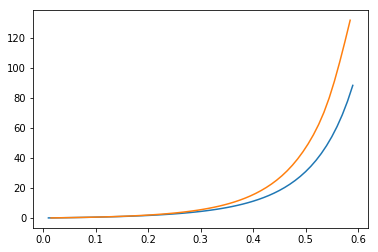

In [95]:
plt.plot(etas, p)
plt.plot(etas_avg, p_num)

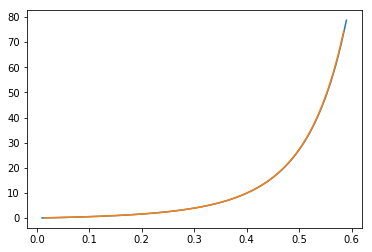

In [85]:
plt.plot(etas, p)
plt.plot(etas_avg, p_num)
#plt.ylim(0,5.0)

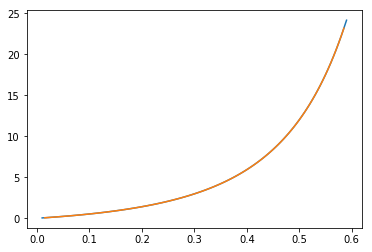

In [81]:
plt.plot(etas, p_CS)
plt.plot(etas_avg, p_CS_num)
#plt.ylim(0,5.0)

In [384]:
etas

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59])

(0, 10)

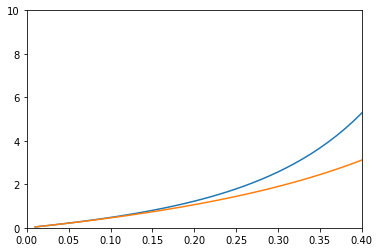

In [351]:
F_P = np.array(F_P)
rhos = 6.0*etas/(np.pi*particle_diameter**3.0)
plt.plot(etas, F_P[:,0]/rhos)
plt.plot(etas, CS(etas))
plt.xlim(0,0.4)
plt.ylim(0,10)

In [362]:
f = CS(etas)
#f = F_P[:,0]/rhos
fr = f[:-1]
ff = f[1:]
favg = (fr+ff)/2.0
rhor = rhos[:-1]
rhof = rhos[1:]
rhoavg = (rhor+rhof)/2.0

#P_num = rhoavg*rhoavg*((ff-fr)/(rhof-rhor))
P_num = -(favg/2.0)/rhoavg + ((ff-fr)/(rhof-rhor))

(0, 0.5)

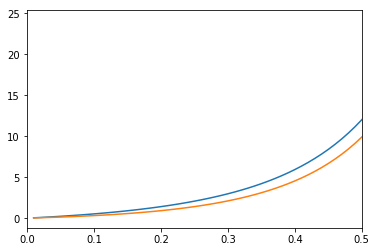

In [365]:
plt.plot(etas, P(etas))
plt.plot(etas[:-1], P_num*rhoavg)
plt.xlim(0,0.5)

(0, 0.5)

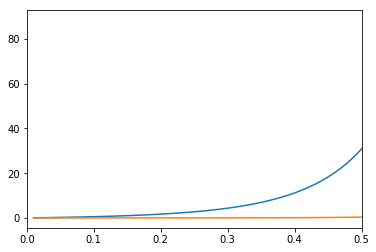

In [357]:
plt.plot(etas, F_P[:,1]/rhos)
plt.plot(etas[:-1], P_num)
plt.xlim(0,0.5)

In [340]:
ff-fr

array([0.04190143, 0.04317283, 0.04458283, 0.04613787, 0.04784514,
       0.04971263, 0.05174921, 0.05396467, 0.05636984, 0.05897668,
       0.06179838, 0.06484952, 0.06814619, 0.07170622, 0.07554931,
       0.07969728, 0.0841743 , 0.08900719, 0.09422569, 0.09986282,
       0.10595522, 0.11254364, 0.11967332, 0.12739458, 0.13576332,
       0.1448417 , 0.15469884, 0.16541292, 0.17706536, 0.18975486,
       0.20358617, 0.21867758, 0.23516119, 0.25318467, 0.2729133 ,
       0.29453238, 0.31824978, 0.34429869, 0.37294045, 0.40446768,
       0.43920919, 0.47753903, 0.51989252, 0.56678588, 0.6188219 ,
       0.67668003, 0.74105563, 0.81258198, 0.89183604, 0.97957386,
       1.07730336, 1.18804063, 1.31653599, 1.46807439, 1.64369965,
       1.83861723, 2.04409145, 2.25395374])

In [136]:
r = PRISM.sys.domain.r
k = PRISM.sys.domain.k

CR = deepcopy(PRISM.directCorr)
ck = deepcopy(CR['particle','particle'])
PRISM.sys.domain.MatrixArray_to_real(CR)
cr = CR['particle','particle']
hr = deepcopy(PRISM.totalCorr['particle','particle'])
rho = PRISM.sys.density['particle']
Fr = -2.0*np.pi*rho*rho*np.trapz(r*r*(cr-(np.heaviside(-hr, 0)*hr**2.0)/2.0), r)
Fk = (1.0/(4.0*np.pi**2.0))*np.trapz(k*k*(rho*ck+np.log(1.0-rho*ck)), k)

Pr = Fr
Pk = -(1.0/(4.0*np.pi**2.0))*np.trapz(k*k*(rho*ck/(1.0-rho*ck)+np.log(1.0-rho*ck)), k)

print Fr, Fk
print Fr+Fk
print Pr, Pk
print Pr+Pk

0.8342097162126321 -0.6942038163970944
0.14000589981553768
0.8342097162126321 -0.12466208035540356
0.7095476358572285


In [107]:
np.array(ExcessFreeEnergy(PRISM))

array([0.1400059 , 0.70954764])

In [141]:
ThermodynamicsClosedForm(PRISM)

set(['custom_prism_tools.KovalenkoHirata'])


(0.14000589981553968, 0.7095476358572341)

## k-space contribution to free energy

In [689]:
Ck = np.ones((len(sys.domain.k), 1+length,1+length), dtype=None, order='C')
Wk = np.ones((len(sys.domain.k), 1+length,1+length), dtype=None, order='C')
p = np.zeros((1+length,1+length), dtype=None, order='C')
k = sys.domain.k

types = ['particle', 'polymer_end', 'polymer_middle']
type_indices = {'particle': [1], 'polymer_end': [1,length], 'polymer_middle': range(2, length)}
single_site_density = {'particle': particle_density, 
                       'polymer_end': polymer_density, 
                       'polymer_middle': polymer_density}

#loops over the rows
row = 0
for type_1 in types:
    for index_1 in type_indices[type_1]:
        
        #loops over the columns
        column = 0
        for type_2 in types:
            for index_2 in type_indices[type_2]:
                
                #build a 3d entry into our tensor
                c = PRISM.directCorr[type_1,type_2]
                Ck[:,row:row+1,column:column+1] = np.expand_dims(np.expand_dims(c, axis=1), axis=1)
                
                #polymer-polymer w(k)
                if type_1 in ['polymer_end', 'polymer_middle'] and type_2 in ['polymer_end', 'polymer_middle']:
                    n = abs(index_1-index_2)
                    if n:
                        w = sys.omega[type_1,type_2].koyama_kernel_fourier(k,n)
                    else:
                        w = np.ones((len(sys.domain.k)), dtype=None, order='C')
                else:
                    w = sys.omega[type_1,type_2].calculate(k)
                    
                Wk[:,row:row+1,column:column+1] = np.expand_dims(np.expand_dims(w, axis=1), axis=1)
                
                p[row:row+1,column:column+1] = (row == column)*single_site_density[type_1]
            
                column += 1
            
        row+=1

In [690]:
trace_1 = np.trace(np.matmul(np.matmul(Wk, Ck), p), axis1=1, axis2=2)
trace_2 = np.trace(np.matmul(np.matmul(p, Wk), Ck), axis1=1, axis2=2)

In [691]:
I=np.repeat(np.expand_dims(np.identity(1+length), axis=0), repeats=len(sys.domain.k), axis=0)
lndet_1 = np.log(np.linalg.det(I-np.matmul(np.matmul(Wk, Ck), p)))
lndet_2 = np.log(np.linalg.det(I-np.matmul(np.matmul(p, Wk), Ck)))

In [692]:
F = 4.0*np.pi/(2.0*(2.0*np.pi)**3)*np.trapz(k*k*(trace_1+lndet_1), k)
print F

-0.06552257255768262


In [134]:
np.array(ThermodynamicsClosedForm(PRISM))

set(['custom_prism_tools.KovalenkoHirata'])


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: UserWarning: This calculation is only theoretically valid if either \                      the KovalenkoHirata (KH) or HyperNettedChain (HNC) \                      closures are used for all pairs. Defaulting to HNC \                      functional form for use with mixed closures.


array([0.22743315, 0.79697488])

#### Testing the PRISM version

In [323]:
sys.density.types

['particle', 'polymer_middle', 'polymer_end']

In [433]:
num_types = len(sys.density.types)

Ck = np.ones((len(sys.domain.k), num_types, num_types), dtype=None, order='C')
Wk = np.ones((len(sys.domain.k), num_types, num_types), dtype=None, order='C')
p = np.zeros((num_types,num_types), dtype=None, order='C')
k = sys.domain.k

#loops over the rows
row = 0
for type_1 in sys.density.types:
        
    #loops over the columns
    column = 0
    for type_2 in sys.density.types:
                
        #build a 3d entry into our tensor
        c = PRISM.directCorr[type_1,type_2]
        Ck[:,row:row+1,column:column+1] = np.expand_dims(np.expand_dims(c, axis=1), axis=1)
        
        w = PRISM.omega[type_1,type_2]
        Wk[:,row:row+1,column:column+1] = np.expand_dims(np.expand_dims(w, axis=1), axis=1)
                
        p[row:row+1,column:column+1] = ((row == column)*sys.density[type_1] + 
                                        (row != column)*(sys.density[type_1] + sys.density[type_2]))
            
        column += 1
            
    row+=1

In [434]:
trace = np.trace(np.matmul(Wk, Ck), axis1=1, axis2=2)

In [435]:
I=np.repeat(np.expand_dims(np.identity(num_types), axis=0), repeats=len(sys.domain.k), axis=0)
lndet = np.log(np.linalg.det(I-np.matmul(Wk, Ck)))

## Free energy and pressure

In [236]:
import pyPRISM
import numpy as np
from itertools import combinations_with_replacement
from copy import deepcopy
import inspect
import warnings

def ThermodynamicsClosedForm(PRISM, default_method='HNC'): 
    
    r'''Calculate the Real-space *inter*-molecular pair correlation function 
    Parameters
    ----------
    PRISM: pyPRISM.core.PRISM
        A **solved** PRISM object.
    
    Returns
    -------
    pairCorr: pyPRISM.core.MatrixArray
        The full MatrixArray of pair correlation functions.
    
    **Mathematical Definition**
    .. math::
         
        g_{\alpha,\beta}(r) = h_{\alpha,\beta}(r) + 1.0
    
    **Variable Definitions**
        - :math:`g_{\alpha,\beta}(r)`
            Pair correlation function between site types :math:`\alpha` and
            :math:`\beta` at a distance :math:`r`
        - :math:`h_{\alpha,\beta}(r)`
            Total correlation function between site types :math:`\alpha` and
            :math:`\beta` at a distance :math:`r`
    **Description**
        The pair correlation function describes the spatial correlations
        between pairs of sites in Real-space. Also known as the *radial
        distribution function* (rdf), the :math:`g(r)` function is
        related to the underlying spatial probability distributions of a given
        system. In a PRISM calculation, :math:`g(r)` is strictly an
        *inter*-molecular quantity.
        After convergence of a PRISM object, the stored total correlation
        attribute function can simply be shifted to obtain the :math:`g(r)` 
    .. warning::
        Passing an unsolved PRISM object to this function will still produce
        output based on the default values of the attributes of the PRISM
        object.
    
    Example
    -------
    .. code-block:: python
        import pyPRISM
        sys = pyPRISM.System(['A','B'])
        
        # ** populate system variables **
        
        PRISM = sys.createPRISM()
        PRISM.solve()
        rdf = pyPRISM.calculate.pair_correlation(PRISM)
        rdf_AA = rdf['A','A']
        rdf_AB = rdf['A','B']
        rdf_BB = rdf['B','B']
    
    '''
    
    #Check on the closures and raise a warning of incompatible.
    #These formulas can be used anyways but they are not theoretically 
    #consistent with the input structure anymore.
    closures = set()
    for type_1, type_2 in combinations_with_replacement(PRISM.sys.types, 2):
        closures.add(dict(inspect.getmembers(PRISM.sys.closure[type_1, type_2]))['__module__'])
    
    if not (closures - set(['custom_prism_tools.KovalenkoHirata'])):
        method = 'KH'
    elif not (closures - set(['pyPRISM.closure.HyperNettedChain'])):
        method = 'HNC'
    else:
        warnings.warn('This calculation is only theoretically valid if either \\
                      the KovalenkoHirata (KH) or HyperNettedChain (HNC) \\
                      closures are used for all pairs. Defaulting to {} \\
                      functional form for use with mixed closures.'.format(default_method), UserWarning)
        method = default_method
    
    #extra quantities for k-space calculation
    k = PRISM.sys.domain.k
    I = pyPRISM.IdentityMatrixArray(length=len(PRISM.sys.domain.k), rank=3, 
                                    types=PRISM.sys.types, space=pyPRISM.Space.Fourier)
    
    #extra quantities for r-space calculation
    r = PRISM.sys.domain.r
    Rho = np.diag(np.diag(PRISM.sys.density.site.data[0]))  #this is a diagonal density matrix
    
    #direct correlation function in r- and k-space
    if PRISM.directCorr.space == pyPRISM.Space.Real:
        Cr = deepcopy(PRISM.directCorr)
        Ck = deepcopy(Cr)
        PRISM.sys.domain.MatrixArray_to_fourier(Ck)
    elif PRISM.directCorr.space == pyPRISM.Space.Fourier:
        Ck = deepcopy(PRISM.directCorr)
        Cr = deepcopy(Ck)
        PRISM.sys.domain.MatrixArray_to_real(Cr)
    
    #intramolecular structure in k-space
    Wk = deepcopy(PRISM.omega)
    if Wk.space == pyPRISM.Space.Real:
        PRISM.sys.domain.MatrixArray_to_fourier(Wk)
    
    #total correlation function in r-space
    Hr = deepcopy(PRISM.totalCorr)
    if Hr.space == pyPRISM.Space.Fourier:
        PRISM.sys.domain.MatrixArray_to_real(Hr)
    
    #calculate the k-space contribution
    #two quantites of relevance to the thermodynamics in k-space
    K1 = Wk.dot(Ck)
    K2 = (I-K1)
    #work with numpy arrays from here on out
    K1 = K1.data                 #WkCk
    K2 = K2.data                 #I-WkCk
    K2inv = np.linalg.inv(K2)    #(I-WkCk)^-1
    
    #specific quantities used in the k-space integrals
    tr_K1 = np.trace(K1, axis1=1, axis2=2)
    tr_K2invK1 = np.trace(np.matmul(K2inv, K1), axis1=1, axis2=2)
    lndet_K2 = np.log(np.linalg.det(K2))
    
    #free energy and pressure k-space contributions
    prefactor_k = 4.0*np.pi/(2.0*(2.0*np.pi)**3)
    F_ex_k = prefactor_k*np.trapz(k*k*(tr_K1 + lndet_K2), k)
    P_ex_k = -prefactor_k*np.trapz(k*k*(tr_K2invK1 + lndet_K2), k)
    
    #calculate the r-space contribution
    if method == 'HNC':
        Structure = ((1.0/2.0)*(Hr*Hr).data*np.heaviside(-Hr.data, 0) - Cr.data)
    elif method == 'KH':
        Structure = ((1.0/2.0)*(Hr*Hr).data - Cr.data)
    kernel_r = np.sum(np.matmul(np.matmul(Rho, Structure), Rho), axis=(1,2))
    F_and_P_ex_r = (4.0*np.pi/2.0)*np.trapz(r*r*kernel_r, r)
    
    #total free energy per volume and kBT
    F_ex = F_and_P_ex_r + F_ex_k
    
    #pressure per kBT (NOT divided by density)
    P_ex = F_and_P_ex_r + P_ex_k
    
    return (F_ex, P_ex)

#### Testing for free energy and pressure consistency

In [237]:
F_P = []
density = []
eta = np.arange(0.01, 0.6, 0.01)
for particle_eta in eta:
    
    #establish particle densities
    particle_density = 6.0*particle_eta/(np.pi*particle_diameter**3.0)
    polymer_density = N_polymer__N_particle*particle_density
    density.append(particle_density+polymer_density)
    polymer_site_density = length*polymer_density
    sys.density['particle'] = particle_density
    sys.density['polymer_end'] = polymer_site_density*(2.0/float(length))
    sys.density['polymer_middle'] = polymer_site_density*(float(length-2)/float(length))
    
    #solve for the structure
    PRISM = sys.solve(guess=guess, method='krylov')
    guess = np.copy(PRISM.x)
    F_P.append(ThermodynamicsClosedForm(PRISM, default_method='HNC'))
    
F_P = np.array(F_P)
density = np.array(density)

0:  |F(x)| = 1.91885e-11; step 1; tol 1.51658e-11
KH
0:  |F(x)| = 0.0274828; step 1; tol 4.16969e-05
1:  |F(x)| = 3.45229e-06; step 1; tol 1.42015e-08
KH
0:  |F(x)| = 0.0319233; step 1; tol 6.01737e-05
1:  |F(x)| = 3.99304e-06; step 1; tol 1.40811e-08
KH
0:  |F(x)| = 0.0362233; step 1; tol 8.2813e-05
1:  |F(x)| = 4.8752e-06; step 1; tol 1.63024e-08
KH
0:  |F(x)| = 0.040272; step 1; tol 0.000109331
1:  |F(x)| = 6.20797e-06; step 1; tol 2.13863e-08
KH
0:  |F(x)| = 0.0440428; step 1; tol 0.00013956
1:  |F(x)| = 7.99628e-06; step 1; tol 2.96668e-08
KH
0:  |F(x)| = 0.0475387; step 1; tol 0.000173385
1:  |F(x)| = 1.02654e-05; step 1; tol 4.19663e-08
KH
0:  |F(x)| = 0.0507777; step 1; tol 0.000210757
1:  |F(x)| = 1.30363e-05; step 1; tol 5.932e-08
KH
0:  |F(x)| = 0.0531745; step 1; tol 0.000246011
1:  |F(x)| = 1.57873e-05; step 1; tol 7.93322e-08
KH
0:  |F(x)| = 0.055907; step 1; tol 0.000289179
1:  |F(x)| = 1.94892e-05; step 1; tol 1.0937e-07
KH
0:  |F(x)| = 0.0585314; step 1; tol 0.00033671

7:  |F(x)| = 3.61608e-05; step 1; tol 0.000622589
KH
0:  |F(x)| = 3.95865; step 1; tol 0.365561
1:  |F(x)| = 1.16074; step 1; tol 0.120272
2:  |F(x)| = 0.512332; step 1; tol 0.175339
3:  |F(x)| = 0.0450569; step 1; tol 0.00696083
4:  |F(x)| = 0.00810526; step 1; tol 0.0291242
5:  |F(x)| = 2.14718e-06; step 1; tol 6.31603e-08
KH
0:  |F(x)| = 4.69146; step 1; tol 0.447972
1:  |F(x)| = 1.31753; step 1; tol 0.180611
2:  |F(x)| = 0.513728; step 1; tol 0.136833
3:  |F(x)| = 0.0870129; step 1; tol 0.0258192
4:  |F(x)| = 0.000719243; step 1; tol 6.14932e-05
5:  |F(x)| = 2.64594e-07; step 1; tol 1.21801e-07
KH


In [238]:
def P_num(f, d, rho):
    fr = f[:-1]
    ff = f[1:]
    favg = (fr+ff)/2.0
    rhor = rho[:-1]
    rhof = rho[1:]
    rhoavg = (rhor+rhof)/2.0
    P_num = -favg/rhoavg + ((ff-fr)/(rhof-rhor))
    return P_num

In [239]:
eta_avg = (eta[1:]+eta[:-1])/2.0

In [240]:
f = F_P[:,0]
p = F_P[:,1]/density
p_num = P_num(f, d=particle_diameter, rho=density)

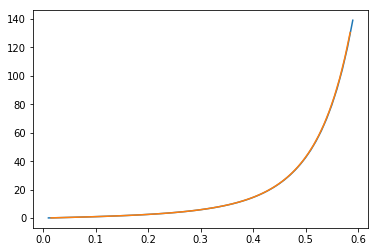

In [228]:
plt.plot(eta, p)
plt.plot(eta_avg, p_num)

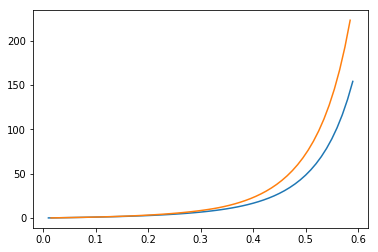

In [241]:
plt.plot(eta, p)
plt.plot(eta_avg, p_num)

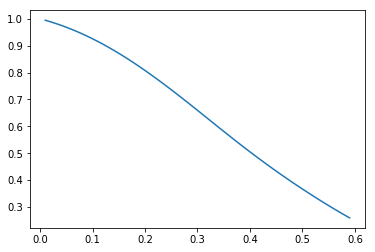

In [247]:
plt.plot(eta, F_P[:,0]/F_P[:,1])
#plt.plot(eta, F_P[:,1])
#plt.ylim(0,0.2)

___
___




In [23]:
sys.omega['particle','particle'].calculate(0.0001)

array(1.)

In [24]:
sys.omega['polymer_end','polymer_end'].calculate(0.0001)

array(1.99999998)

In [25]:
sys.omega['polymer_middle','polymer_middle'].calculate(0.0001)

array(7.99999995)

In [63]:
PRISM.sys.density.site.data

array([[[6.11154981e-03, 6.11154987e-03, 6.11154983e-03],
        [6.11154987e-03, 5.37816384e-11, 6.72270480e-11],
        [6.11154983e-03, 6.72270480e-11, 1.34454096e-11]]])

In [108]:
np.array(ExcessFreeEnergy(PRISM))/PRISM.sys.density.total

array([1.12781495, 1.6012601 ])

In [287]:
def CS(n):
    return ((4.0*n-3.0*n*n)/(1.0-n)**2)

In [288]:
CS(0.00001)

4.000050000600007e-05

In [93]:
def P(n):
    return (1.0+n+n**2.-n**3.)/(1.0-n)**3.0 - 1.0

In [112]:
P(0.2)

1.4062499999999996

In [ ]:
PRISM.sys

In [816]:
type(PRISM.sys.closure['particle','polymer_middle']) == type(KovalenkoHirata())

True

In [58]:
def P(n):
    return (1.0+n+n**2-n**3)/(1.0-n)**3.0

In [76]:
P(0.1)

1.5212620027434842

In [48]:
k = sys.domain.k
I = pyPRISM.IdentityMatrixArray(length=len(sys.domain.k), rank=3, types=sys.types, space=pyPRISM.Space.Fourier)
Ck = PRISM.directCorr
Wk = PRISM.omega
tr_WkCk = np.trace(Wk.dot(Ck).data, axis1=1, axis2=2)
lndet_WkCk = np.log( np.linalg.det( (I-Wk.dot(Ck)).data ) )
F_ex_k = -4.0*np.pi/(2.0*(2.0*np.pi)**3)*np.trapz(k*k*(tr_WkCk + lndet_WkCk), k)

In [49]:
from copy import deepcopy

In [50]:
r = sys.domain.r
Cr = deepcopy(Ck)
sys.domain.MatrixArray_to_real(Cr)
p = np.diag(np.diag(sys.density.site.data[0]))
Hr = PRISM.totalCorr
structure = ((1.0/2.0)*(Hr*Hr).data*np.heaviside(-Hr.data, 0) - Cr.data)
kernel_r = np.sum(np.matmul(np.matmul(p, structure), p), axis=(1,2))
F_ex_r = (4.0*np.pi/2.0)*np.trapz(r*r*kernel_r, r)

In [51]:
print F_ex_r 
print F_ex_k
print F_ex_r - F_ex_k

0.07593789425862679
0.05186935437474227
0.02406853988388452


In [54]:
ExcessFreeEnergy(PRISM)

[-9.57867439e-01 -9.56554119e-01 -9.54215971e-01 ...  4.21616959e-08
  5.58464540e-08  6.06266928e-08]


(0.02406853988388452, 0.09374076122401831)

In [38]:
def CS(n):
    return ((4.0*n-3.0*n*n)/(1.0-n)**2)

In [77]:
CS(0.2)

1.0624999999999998